In [ ]:
# !pip install xgboost
# !pip install fuzzywuzzy
# !pip install catboost
# !pip install scikit-plot

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from mpl_toolkits.mplot3d import axes3d
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from pandas.api.types import is_numeric_dtype
from xgboost import XGBClassifier
import warnings
from scipy.stats import kurtosis
from fuzzywuzzy import fuzz
from catboost import CatBoostClassifier
import scikitplot as skplt
import pickle

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)

C:\Users\DELL\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Paratemers

In [2]:
path="C:\\Users\\DELL\\Desktop\\Job Interviews\\Navi Technologies\\"
filename_1="dataset.csv"             # Modeling Dataset
filename_2="data_dictionary_v1.xlsx" # Data Dictionary

### Data Import  

In [3]:
class Data_Import:
    def data_generate():
        data=pd.read_csv(path+filename_1)
        data_dictionary=pd.read_excel(path+filename_2)
        data_modeling=data[data['label']=='modeling']
        data_oot=data[data['label']=='oot']
        
        print("Rows and Columns:",data_modeling.shape)        
        return(data_modeling,data_oot,data_dictionary)    

In [4]:
data_modeling, data_oot, data_dictionary= Data_Import.data_generate()
data_dictionary_1 = pd.Series(data_dictionary['description'].values,index=data_dictionary['Rename']).to_dict()

print("Default rate:",'{:,.2%}'.format(data_modeling['default'].sum()/data_modeling['default'].count()))

Rows and Columns: (4661, 360)
Default rate: 22.51%


## Univariate Analysis

In [5]:
data_EDA=data_modeling.copy()

def data_summary():
    data_summary=data_EDA.describe().T
    data_summary['Rename']=data_summary.index
    data_summary=pd.merge(left = data_summary, right = data_dictionary, left_on='Rename', right_on='Rename', how='left')
    return(data_summary)

data_summary().head()

,count,mean,std,min,25%,50%,75%,max,Rename,description
0,4661.0,0.225059,0.417666,0.0,0.00,0.00,0.00,1.00,default,NaN
1,3724.0,1.669173,2.758058,0.0,0.00,1.00,2.00,58.00,v1,# NEGATIVE EVENTS IN LAST 6 MONTHS (LOANS)
2,4509.0,290933.140448,978141.889379,0.0,18435.51,52354.00,151006.45,32284841.25,v2,AVG. MONTHLY CREDIT TRANSACTIONS AMOUNT LAST 180 DAYS
3,4501.0,22127.802742,76844.391372,0.0,1119.82,5608.19,16446.96,3117544.20,v3,AVG. OF MINIMUM BALANCE PER MONTH LAST 360 DAYS
4,4444.0,0.143114,0.527220,0.0,0.00,0.00,0.00,7.00,v4,# RECHARGES LAST 150-180 DAYS


distance_from_pin_code


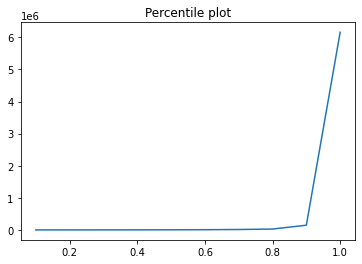

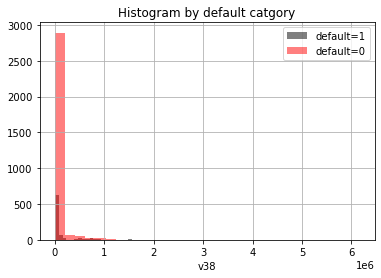

In [6]:
# for numerical variables
def Distribution(col):
    plt.figure(figsize=(6,4))
    data_EDA[data_EDA['default']==1][col].hist(alpha=0.5,color='black', bins=30,label='default=1')
    data_EDA[data_EDA['default']==0][col].hist(alpha=0.5,color='red', bins=30,label='default=0')
    plt.legend()
    plt.xlabel(col)
    plt.title('Histogram by default catgory')

def percentile_plot(variable):
    a=[i/10 for i in list(range(1,11))]
    plt.plot(data_EDA[[variable]].apply(lambda x: x.quantile(a)))
    plt.title('Percentile plot')

var = 'v38'
print(data_dictionary_1[var])
percentile_plot(var)
Distribution(var)

No of unique values: 6


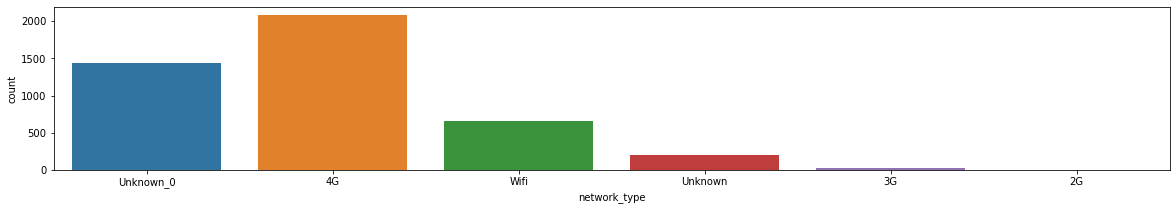

In [7]:
# for chategorical variables (will be helpful to check data quality)
def Histogram_plot(variable):
    print('No of unique values:',data_EDA[variable].nunique())
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.countplot(data_EDA[variable])
    
Histogram_plot('network_type')

## Missing value treatment

In [8]:
class EDA:            
        def missing_value_check(df):
            data_missing=pd.DataFrame(df.isna().sum().where(lambda x : x>0).dropna()) 
            data_missing.columns=['Missing Count']
            data_missing['pct_missing']=round(data_missing['Missing Count']*100/df.shape[0],1)
            data_missing['Rename']=data_missing.index.values
            data_missing = pd.merge(left = data_missing, right = data_dictionary, left_on='Rename', right_on='Rename', how='left')
            return(data_missing)
            
        def missing_value_treatment(df,Missing_treatment):
            Name=[]
            Value=[]

            for i,(fun,variable) in enumerate(Missing_treatment.items()):
                if fun=='avg':
                    for j in variable:
                        df[j]=df[j].fillna(df[j].mean())
                        Name.append(j)
                        Value.append(data_modeling[j].mean())


                if fun=='zero':
                    for j in variable:
                        df[j]=df[j].fillna(0)
                        Name.append(j)
                        Value.append(0)

                if fun=='Frequency':
                    for j in variable.tolist():
                        df[j]=df[j].fillna(pd.Series(df[j].value_counts()).sort_values(ascending=False).index.tolist()[0])
                        Name.append(j)
                        Value.append(pd.Series(df[j].value_counts()).sort_values(ascending=False).index.tolist()[0])
            Missing_Impute=pd.DataFrame(zip(Name,Value), columns=['Variable','Missing_value_treated'])                     
            return(df,Missing_Impute)

 v27: AVG. DAILY DEBIT LAST 30 DAYS BY AVG. DAILY DEBIT LAST 60-120 DAYS 
 v90: AVG. MONTHLY CREDIT LAST 30 DAYS BY AVG. MONTHLY CREDIT LAST 60-120 DAYS 
 v131: AVG. MONTHLY DEBIT LAST 30 DAYS BY AVG. MONTHLY DEBIT LAST 60-120 DAYS 
 v260: AVG. ATM WITHDRAWAL AMOUNT PER TRANSACTION LAST 360 DAYS 
 v300: AVG. ATM WITHDRAWAL AMOUNT PER TRANSACTION LIFETIME


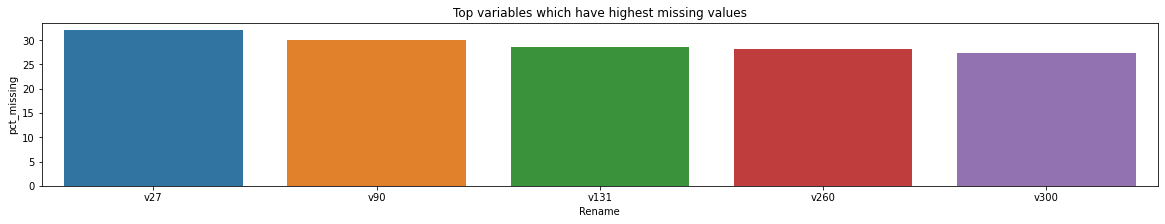

In [9]:
data_missing = EDA.missing_value_check(data_modeling)

# Checking top variables which have highest missing values
Variables_excluded=['cloned_details','allow_mock_locations','otp_autofill','default']
fig, ax = plt.subplots(figsize=(20, 3))
sns.barplot(y='pct_missing', x='Rename', data=data_missing[~data_missing['Rename'].isin(Variables_excluded)].sort_values(by='pct_missing',ascending=False).head(5))
plt.title("Top variables which have highest missing values")
print(' v27:',data_dictionary_1['v27'],'\n','v90:',data_dictionary_1['v90'],'\n','v131:',data_dictionary_1['v131'],'\n','v260:',data_dictionary_1['v260'],'\n','v300:',data_dictionary_1['v300'])

columns_zero=['v1',	'v4',	'v7',	'v9',	'v13',	'v16',	'v20',	'v21',	'v22',	'v26',	'v29',	'v35',	'v36',	'v37',	'v40',	'v44',	'v47',	'v50',	'v52',	'v54',	'v68',	'v71',	'v73',	'v84',	'v85',	'v86',	'v88',	'v92',	'v94',	'v99',	'v101',	'v112',	'v116',	'v117',	'v122',	'v123',	'v128',	'v130',	'v132',	'v134',	'v137',	'v139',	'v140',	'v146',	'v151',	'v158',	'v160',	'v163',	'v165',	'v166',	'v170',	'v175',	'v176',	'v183',	'v184',	'v185',	'v187',	'v188',	'v196',	'v198',	'v199',	'v200',	'v213',	'v218',	'v220',	'v221',	'v226',	'v232',	'v234',	'v240',	'v242',	'v243',	'v245',	'v246',	'v249',	'v252',	'v255',	'v273',	'v274',	'v276',	'v277',	'v278',	'v283',	'v285',	'v286',	'v289',	'v290',	'v294',	'v295',	'v298',	'v299',	'v302',	'v304',	'v305',	'v310',	'v312',	'v313',	'v315',	'v316',	'v319',	'v324',	'v325',	'v326',	'v327',	'v331',	'v333',	'v342']
columns_num=data_modeling.select_dtypes(exclude=np.object).columns
columns_num=list(filter(lambda x: x not in columns_zero, columns_num.tolist()))
columns_char=data_modeling.select_dtypes(include=np.object).columns

#Creating a dictionary to store missing treatment applied for each column
Missing_treatment = {"avg":columns_num, "zero":columns_zero, "Frequency":columns_char}
Missing_treatment_file = open('Missing_treatment_pkl', 'wb')
pickle.dump(Missing_treatment, Missing_treatment_file)
Missing_treatment_file.close()

data_modeling_treated, Missing_Impute=EDA.missing_value_treatment(data_modeling,Missing_treatment)

Missing_Impute_file = open('Missing_Impute_pkl', 'wb')
pickle.dump(Missing_Impute, Missing_Impute_file)
Missing_Impute_file.close()


## Bivariate Analysis

Checking the relationship of a variable with default rate. Will be useful to validate the hypothesis- how default rate vary wrt to a variable

Default Response Rate: 22.51% 

2G has the highest default rate. Maybe because these customers have low financial stability that's why they are using low budgeted phone (non 3G/4G supported)



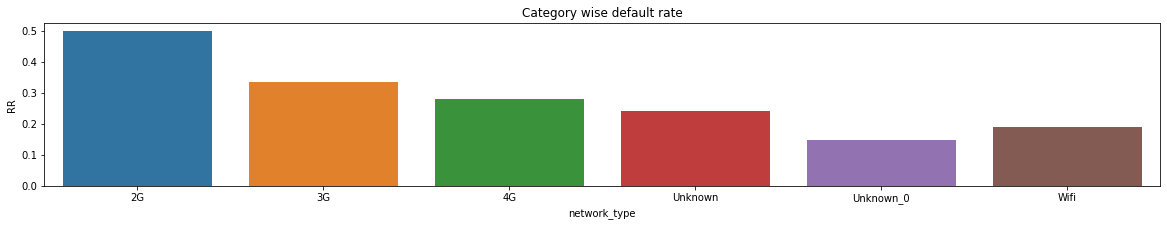

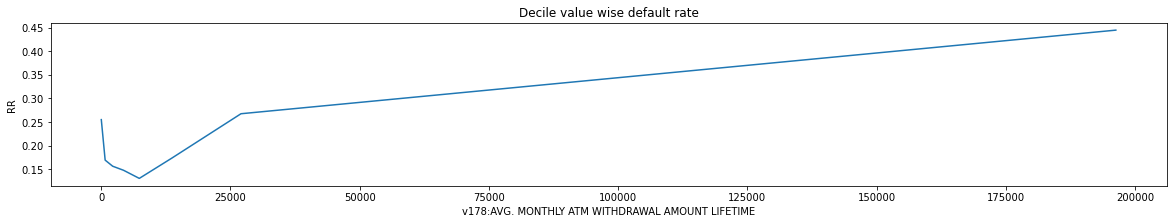

In [10]:
print('Default Response Rate:','{:,.2%}'.format(data_modeling_treated['default'].sum()/data_modeling_treated['default'].count()),'\n')
data_EDA=data_modeling_treated.copy()

def RR_char_variable(col):
    RR_temp = data_EDA.groupby(col)['default'].agg(['sum','count'])
    RR_temp['RR']=RR_temp['sum']/RR_temp['count']
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.barplot(y=RR_temp['RR'], x=RR_temp.index)
    plt.title("Category wise default rate")

def RR_numeric_variable(variable):
    Decile_temp=data_EDA
    Decile_temp['Decile'] = pd.qcut(Decile_temp[variable], 10,labels = False, duplicates='drop') 

    RR_temp = Decile_temp.groupby('Decile').agg({variable:['mean'], 'default':['sum','count']})
    RR_temp.columns=['Var','sum','count']
    RR_temp['RR']=RR_temp['sum']/RR_temp['count']
    fig, ax = plt.subplots(figsize=(20, 3))
    fig=sns.lineplot(y=RR_temp['RR'], x=RR_temp['Var'])
    plt.xlabel(variable+":"+data_dictionary_1['v178'])
    plt.title("Decile value wise default rate")

RR_char_variable('network_type'); print("2G has the highest default rate. Maybe because these customers have low financial stability that's why they are using low budgeted phone (non 3G/4G supported)")
RR_numeric_variable('v178'); print("")

## Information value



In [11]:
def IV(col, data_EDA):
    if is_numeric_dtype(data_EDA[col])==False:
        IV_temp = data_EDA.groupby(col)['default'].agg(['sum','count'])
    elif is_numeric_dtype(data_EDA[col])==True:
        data_EDA['Decile'] = pd.qcut(data_EDA[col], 10,labels = False, duplicates='drop') 
        IV_temp = data_EDA.groupby('Decile')['default'].agg(['sum','count'])
    
    IV_temp['Goods']=IV_temp['sum']
    IV_temp['Bad']=(IV_temp['count']-IV_temp['sum'])
    IV_temp['percent_Goods']=IV_temp['Goods']/IV_temp['Goods'].sum()
    IV_temp['percent_Bads']=IV_temp['Bad']/IV_temp['Bad'].sum()
    IV_temp['IV']=np.log(IV_temp['percent_Goods']/IV_temp['percent_Bads'])*(IV_temp['percent_Goods'] - IV_temp['percent_Bads'])
    IV_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
    IV_temp.dropna(inplace=True)
    return IV_temp['IV'].sum()

Value=[]
Variable=[]

for i in data_dictionary_1.keys():
    Value.append(IV(i,data_EDA))
    Variable.append(i)

Information_value=pd.DataFrame(list(zip(Variable,Value)), columns=['Rename','IV'])
Information_value=Information_value[Information_value['IV']>0.1].sort_values(by='IV', ascending=False)
Information_value=pd.merge(left = Information_value, right = data_dictionary, left_on='Rename', right_on='Rename', how='left')
Information_value.head(5)

,Rename,IV,description
0,v173,0.267861,count_of_unique_banks_having_casa_relationships_with
1,v174,0.256896,AVG. DAILY CREDIT TRANSACTIONS AMOUNT LAST 30 DAYS
2,v288,0.254428,AVERAGE SURPLUS PER MONTH
3,v284,0.247866,count_casa_accounts
4,v262,0.240492,total_credit_transaction_amount_last_30_days


## Feature Engineering

In [12]:
Network = ['Jio','Airtel','Idea','BSNL','Vodafone','Vi','CELLONE'] # list of all network providers
Brand   =['OPPO', 'vivo', 'samsung', 'Xiaomi', 'HONOR'] # list of all phone brands

class Fuzzy_Matching:
    
    def Network_matching_function(x):
            Ratio=[]
            for i in Network:
                Ratio.append(fuzz.ratio(x['carrier'].lower(),i.lower()))
            return(Network[Ratio.index(max(Ratio))])

    def Brand_matching_function(x):
            Ratio=[]
            for i in Brand:
                Ratio.append(fuzz.ratio(x['brand'].lower(),i.lower()))
            return(Brand[Ratio.index(max(Ratio))])

class Feature_Engineering:
    
    def New_Feature(data):
        "Feature 1- [LOAN DISBURSEMENT AMOUNT LAST 180 DAYS] / [MONTHLY AVERAGE BALANCE LAST 180 DAYS]"
        data['New_v1']=data['v10']/(data['v108']+0.0000001)

        "Feature 2- Phone manufacturer (spelling correction)"
        data['New_v2']=data[['manufacturer']].apply(lambda x: x if (x.str.len() < 12).all() else 'None', axis=1)

        "Feature 3- Phone network (spelling correction)"
        data['carrier'].fillna('None',inplace=True)        
        data['New_v3']=data[['carrier']].apply(Fuzzy_Matching.Network_matching_function,  axis=1)

        "Feature 4- Phone brand (spelling correction)"
        data['brand'].fillna('None',inplace=True)        
        data['New_v4']=data[['brand']].apply(Fuzzy_Matching.Brand_matching_function,  axis=1)

        return(data)
    
    def New_Feature_IV(data, New_features):
        Value=[]
        Variable=[]
        for i in New_features:
            Value.append(IV(i,data))
            Variable.append(i)
            Information_value=pd.DataFrame(list(zip(Variable,Value)), columns=['Rename','IV'])
        return(Information_value)

New_features=['New_v1','New_v2','New_v3','New_v4']

data_modeling_featured=Feature_Engineering.New_Feature(data_modeling_treated)

Information_value_New_Feature=Feature_Engineering.New_Feature_IV(data_modeling_featured,New_features)
Information_value_New_Feature.head()

,Rename,IV
0,New_v1,0.071807
1,New_v2,0.351322
2,New_v3,0.085384
3,New_v4,0.024298


## Model Building

Training (Row, Columns): (3728, 360) (3728,)
Testing (Row, Columns): (933, 360) (933,) 

Default rate (Train): 22.83%
Default rate (Test): 21.22%


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

ROC Score: 59.58%
Accuracy 80.49%
Precision: 95.92%
Recall: 82.26%

 Confusion Matrix: 
 [[705  30]
 [152  46]]


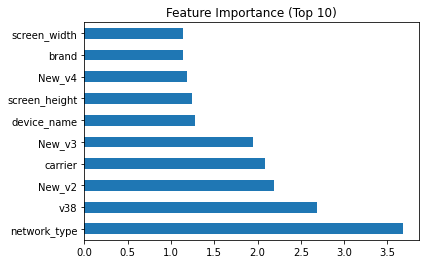

In [13]:
class Model_training:
    
    def train_test_split(df):
        Non_modeling_variables=['decision_id','label','gms_version','default','default_treated','Decile']
        X_train, X_test, y_train, y_test = train_test_split(df.loc[:,~df.columns.isin(Non_modeling_variables)], df['default'], test_size = 0.2, random_state = 42)

        print('Training (Row, Columns):', X_train.shape, y_train.shape)
        print('Testing (Row, Columns):', X_test.shape, y_test.shape,"\n")
        print("Default rate (Train):",'{:,.2%}'.format(sum(y_train)/len(y_train)))
        print("Default rate (Test):",'{:,.2%}'.format(sum(y_test)/len(y_test)))
        return(X_train, X_test, y_train, y_test)
    
    def Modeling(df1, df2, df3, df4):
        categorical_features_indices = np.where(df1.dtypes != np.float)[0]
        Catboost = CatBoostClassifier(iterations=300, depth=10,cat_features=categorical_features_indices,
                              learning_rate=0.03, loss_function='Logloss',eval_metric='AUC',verbose=False)
        Catboost.fit(df1, df3, cat_features=None, plot=True)
        Predict=Catboost.predict(df2)
        Predict_prob= np.min(Catboost.predict_proba(df2), axis=1)
        return(Predict, Predict_prob, Catboost)
        
    def Metric(y_test,Predict):
        print("ROC Score:", '{:,.2%}'.format(roc_auc_score(y_test, Predict)))
        print("Accuracy", '{:,.2%}'.format(metrics.accuracy_score(y_test, Predict.round())))
        print('Precision:', '{:,.2%}'.format(confusion_matrix(y_test, Predict.round())[0][0]/sum(confusion_matrix(y_test, Predict.round())[0])))
        print('Recall:','{:,.2%}'.format(confusion_matrix(y_test, Predict.round())[0][0]/(confusion_matrix(y_test, Predict.round())[0][0]+confusion_matrix(y_test, Predict.round())[1][0])))
        print('\n','Confusion Matrix:','\n',confusion_matrix(y_test, Predict.round()))

    def Feature_importance(Catboost):
        
        feature_importances = pd.DataFrame(Catboost.feature_importances_,index = X_train.columns,columns=['importance']).sort_values('importance',  ascending=False)
        feature_importances['Rename']=feature_importances.index
        feature_importances=pd.merge(left = feature_importances, right = data_dictionary, left_on='Rename', right_on='Rename', how='left')
        feature_importances = pd.Series(Catboost.feature_importances_, index = X_train.columns)
        feature_importances.nlargest(10).plot(kind='barh')
        plt.title("Feature Importance (Top 10)")
    
    def Model_Inference(df,Catboost):
        Predict_prob= np.min(Catboost.predict_proba(df), axis=1)
        return(Predict_prob)
    
    def Model_save(Catboost):
        with open('Catboost_model_pkl', 'wb') as files:
            pickle.dump(Catboost, files)

    def Model_load():
        with open('Catboost_model_pkl' , 'rb') as f:
            Catboost_Inference = pickle.load(f)
        return(Catboost_Inference)
    
    def Depandencies_load():            
        with open('Missing_Impute_pkl' , 'rb') as f:
            Missing_Impute = pickle.load(f)
        return(Missing_Impute)

    def missing_value_treatment_inference(df,Missing_Impute):    
        Missing_Impute=pd.Series(Missing_Impute['Missing_value_treated'].values,index=Missing_Impute['Variable']).to_dict()
        for i in Missing_Impute.keys():
            df[i].fillna(Missing_Impute[i], inplace=True)
        return(df)

X_train, X_test, y_train, y_test=Model_training.train_test_split(data_modeling_featured)
Predict, Predict_prob, Catboost=Model_training.Modeling(X_train, X_test, y_train, y_test)
Model_training.Metric(y_test,Predict)
Model_training.Feature_importance(Catboost)

Model_training.Model_save(Catboost)

## RoC Curve

AUC 59.58%


Text(0.5, 1.0, 'Receiver operating characteristic example')

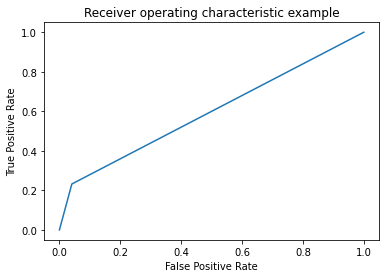

In [14]:
# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test,  Predict.round())
auc = metrics.roc_auc_score(y_test, Predict.round())
print("AUC",'{:,.2%}'.format(auc))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

## KS table and Gain chart

   Decile  default  non_default  Default_Rate  pct_default  pct_non_default  cumm_pct_default  cumm_pct_non_default Difference
0       1     46.0         48.0      0.489362     0.232323         0.065306          0.232323              0.065306     16.70%
1       2     32.0         61.0      0.344086     0.161616         0.082993          0.393939              0.148299     24.56%
2       3     27.0         66.0      0.290323     0.136364         0.089796          0.530303              0.238095     29.22%
3       4     23.0         70.0      0.247312     0.116162         0.095238          0.646465              0.333333     31.31%
4       5     20.0         73.0      0.215054     0.101010         0.099320          0.747475              0.432653     31.48%
5       6     13.0         81.0      0.138298     0.065657         0.110204          0.813131              0.542857     27.03%
6       7     15.0         78.0      0.161290     0.075758         0.106122          0.888889              0.64

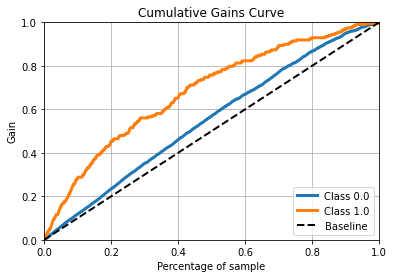

In [15]:
Actual_Predict=pd.DataFrame(zip(y_test,Predict_prob), columns=['Actual','Predict'])

Actual_Predict['Decile'] =10-pd.qcut(Actual_Predict['Predict'], 10, labels = False, duplicates='drop') 
KS_table= Actual_Predict.groupby('Decile')['Actual'].agg(['sum','count']).reset_index()
KS_table['default']=KS_table['sum']
KS_table['non_default']=KS_table['count'] - KS_table['sum']
KS_table['Default_Rate']=KS_table['default']/KS_table['count'] 
KS_table.drop(['sum','count'],axis=1, inplace=True)

KS_table['pct_default']=KS_table['default']/KS_table['default'].sum()
KS_table['pct_non_default']=KS_table['non_default']/KS_table['non_default'].sum()
KS_table['cumm_pct_default']=KS_table['pct_default'].cumsum()
KS_table['cumm_pct_non_default']=KS_table['pct_non_default'].cumsum()

KS_table['Difference']=KS_table['cumm_pct_default'] - KS_table['cumm_pct_non_default'] 
KS_table_1 = KS_table.to_string(formatters={'Difference': '{:,.2%}'.format})
print(KS_table_1, '\n\n', "KS:", '{:,.2%}'.format(KS_table['Difference'].max()))

skplt.metrics.plot_cumulative_gain(y_test, Catboost.predict_proba(X_test))
plt.show()

## Model Inferencing 
Scoring 'oot' data

In [16]:
# Loading the model and dependancies 
Catboost_Model_Inference = Model_training.Model_load()
Missing_Impute = Model_training.Depandencies_load()

# Pre-processing pipeline (Imputing missing values calculated from training dataset)
data_oot_treated=Model_training.missing_value_treatment_inference(data_oot,Missing_Impute)
data_oot_featured=Feature_Engineering.New_Feature(data_oot_treated)

# Model scoring
Non_modeling_variables=['decision_id','label','gms_version','default','default_treated','Decile']
X_oot = data_oot_featured.loc[:,~data_oot_featured.columns.isin(Non_modeling_variables)]
Scoring= np.min(Catboost_Model_Inference.predict_proba(X_oot), axis=1)

# Submission file
Submission=data_oot_featured[['decision_id','label']]
Submission['pd']=Scoring
Submission.to_csv('Submission.csv')

In [17]:
Submission.head()

,decision_id,label,pd
4661,7a74c817-f036-4214-ade0-e5bfa07fd0fc,oot,0.146328
4662,7ba155b6-ce2c-432e-a717-163acd6306da,oot,0.293558
4663,831a2f46-dbb4-47a9-9f3b-91ff7d0214d2,oot,0.204604
4664,d4ec4849-b80e-49e9-a8a5-0e17f7d96c02,oot,0.083564
4665,e67c5ff3-3751-40d4-b621-4987df98ce1b,oot,0.104859


## END